# Classic Machine Learning Workflow

---

This notebook demonstrates the classic ML workflow outlined in notebooks 6, and 7. Here, we predict values for points upstream, middle, or near the terminus. Clean datasets are required for each point.

### 1. Load packages and open dataset

In [168]:
import pandas as pd
import numpy as np
import plotly.express as px
import time
import matplotlib.pyplot as plt
from pycaret.regression import *

In [169]:
point_name = 'middle' # 'upstream', 'middle', or 'terminus'

In [170]:
df = pd.read_csv('../data/clean/' + point_name + '_velocity_series_clean.csv')

df.head()

,time,VelocitySeries
0,2015-01-30 12:00:00,779.53534
1,2015-02-11 12:00:00,738.42413
2,2015-07-29 12:00:00,741.93330
3,2015-09-03 12:00:00,736.29333
4,2015-09-15 12:00:00,731.44696


Create a monthly rolling average of the data to plot with the velocity data.

In [171]:
# create 12 month moving average
df.rename(columns={'VelocitySeries': 'velocity'}, inplace=True)
df['MA12'] = df['velocity'].rolling(12).mean()

# plot the data and monthly average
fig = px.line(df, x="time", y=["velocity", "MA12"], template = 'plotly_dark')
fig.show()

Create a series to add to the dataframe for interpretation of time series data. Drop the values that are unnecessary, leaving series, time, and velocity values.

In [172]:
# create a sequence of numbers
df['series'] = np.arange(1,len(df)+1)
df['time'] = pd.to_datetime(df['time'])

# drop unnecessary columns and re-arrange
df = df[['series', 'time', 'velocity']] 

# check the head of the dataset
df.head()

,series,time,velocity
0,1,2015-01-30 12:00:00,779.53534
1,2,2015-02-11 12:00:00,738.42413
2,3,2015-07-29 12:00:00,741.93330
3,4,2015-09-03 12:00:00,736.29333
4,5,2015-09-15 12:00:00,731.44696


Save the AI-ready dataframe with the series column.

In [173]:
df.to_csv('../data/ai_ready/' + point_name + '_timeseries.csv', index=False)

df = pd.read_csv('../data/ai_ready/' + point_name + '_timeseries.csv')
df.head()

,series,time,velocity
0,1,2015-01-30 12:00:00,779.53534
1,2,2015-02-11 12:00:00,738.42413
2,3,2015-07-29 12:00:00,741.93330
3,4,2015-09-03 12:00:00,736.29333
4,5,2015-09-15 12:00:00,731.44696


Split the data into train and test data. We will use ~75% for training and ~25% for testing.

In [174]:
df['time'] = pd.to_datetime(df['time'])

# split data into train-test set
train = df[df['time'] < pd.to_datetime('06-01-2021')]
test = df[df['time'] >= pd.to_datetime('06-01-2021')]

# check shape
print("Shape of training data:", train.shape, "Shape of test data:", test.shape)

# calculate percentage
train_percentage = (len(train) / len(df)) * 100
test_percentage = (len(test) / len(df)) * 100

print(f"Training data percentage: {train_percentage:.2f}%")
print(f"Testing data percentage: {test_percentage:.2f}%")

Shape of training data: (272, 3) Shape of test data: (92, 3)
Training data percentage: 74.73%
Testing data percentage: 25.27%


### 3. Initialize the model

Here we will use Pycaret's setup function to initialize the model, passing the training data, testing data, and the features to predict. The function outputs information about the pipeline that will be used for model selection and tuning.

In [175]:
# initialize setup
s = setup(data = train, test_data = test, 
          target = 'velocity', fold_strategy = 'timeseries', 
          numeric_features = ['time', 'series'], fold = 10, 
          transform_target = True, session_id = 123,
          data_split_shuffle = False, fold_shuffle = False)

,Description,Value
0,Session id,123
1,Target,velocity
2,Target type,Regression
3,Original data shape,"(364, 3)"
4,Transformed data shape,"(364, 5)"
5,Transformed train set shape,"(272, 5)"
6,Transformed test set shape,"(92, 5)"
7,Numeric features,2
8,Date features,1
9,Preprocess,True


### 4. Compare models

Now, we can compare the models using cross-validation. We sort them based on the mean absolute error (MAE) value which is a measure of error that is not as sensitive to outliers are mean squared error and root mean squared error. We'll also test the first 4 models on the test data, so select those with `n_select`.

In [176]:
# Test the models
comparison = compare_models(n_select=4, sort='MAE', cross_validation=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,31.4361,2225.9147,44.1856,-0.7503,0.0537,0.0384,0.0660
ada,AdaBoost Regressor,35.6793,2561.4955,48.2397,-1.3645,0.0588,0.0435,0.0120
et,Extra Trees Regressor,36.0432,2735.0325,48.7077,-1.3405,0.0594,0.0440,0.0150
lar,Least Angle Regression,36.3794,2826.4439,47.9333,-1.1297,0.0583,0.0455,0.0060
ridge,Ridge Regression,37.0945,2978.1135,48.9743,-1.2873,0.0595,0.0464,0.0060
omp,Orthogonal Matching Pursuit,37.9754,3007.0358,49.4812,-1.4924,0.0601,0.0476,0.0060
dummy,Dummy Regressor,38.4435,2601.1221,47.9499,-1.3542,0.0582,0.0460,0.0060
rf,Random Forest Regressor,38.6190,2783.5259,49.6966,-2.7909,0.0610,0.0475,0.0190
gbr,Gradient Boosting Regressor,39.0398,2934.1325,50.6737,-2.5415,0.0621,0.0474,0.0210
en,Elastic Net,39.3257,2628.6182,48.7408,-1.6600,0.0591,0.0477,0.0060


Let's test the best model on the test set.

In [177]:
prediction_holdout = predict_model(comparison[0]);

Sometimes, the model performs worse on the test data. Let's test next 3 models and see which performs well on the test data.

In [178]:
# Initialize a dictionary to store the MAE scores
mae_scores = {}

# Iterate through the top 4 models and test them on the test data
for model in comparison:
    # Predict on the test data
    predictions = predict_model(model, data=test)
    
    # Calculate the MAE score
    mae = np.mean(np.abs(predictions['velocity'] - predictions['prediction_label']))
    
    # Store the MAE score in the dictionary
    mae_scores[model] = mae

# Determine the model with the best MAE score
best_model = min(mae_scores, key=mae_scores.get)
best_mae_score = mae_scores[best_model]

print(f"The best model is {best_model} with a MAE score of {best_mae_score:.4f}")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,38.1687,2370.2136,48.6848,-0.1064,0.0580,0.0447


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,45.5108,3118.1159,55.8401,-0.4555,0.0663,0.0531


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,32.4732,1857.3332,43.0968,0.1330,0.0514,0.0384


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,47.9550,4259.5550,65.2653,-0.9883,0.0771,0.0581


The best model is ExtraTreesRegressor(n_jobs=-1, random_state=123) with a MAE score of 32.4732


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,38.1687,2370.2136,48.6848,-0.1064,0.0580,0.0447


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,45.5108,3118.1159,55.8401,-0.4555,0.0663,0.0531


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,32.4732,1857.3332,43.0968,0.1330,0.0514,0.0384


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,47.9550,4259.5550,65.2653,-0.9883,0.0771,0.0581


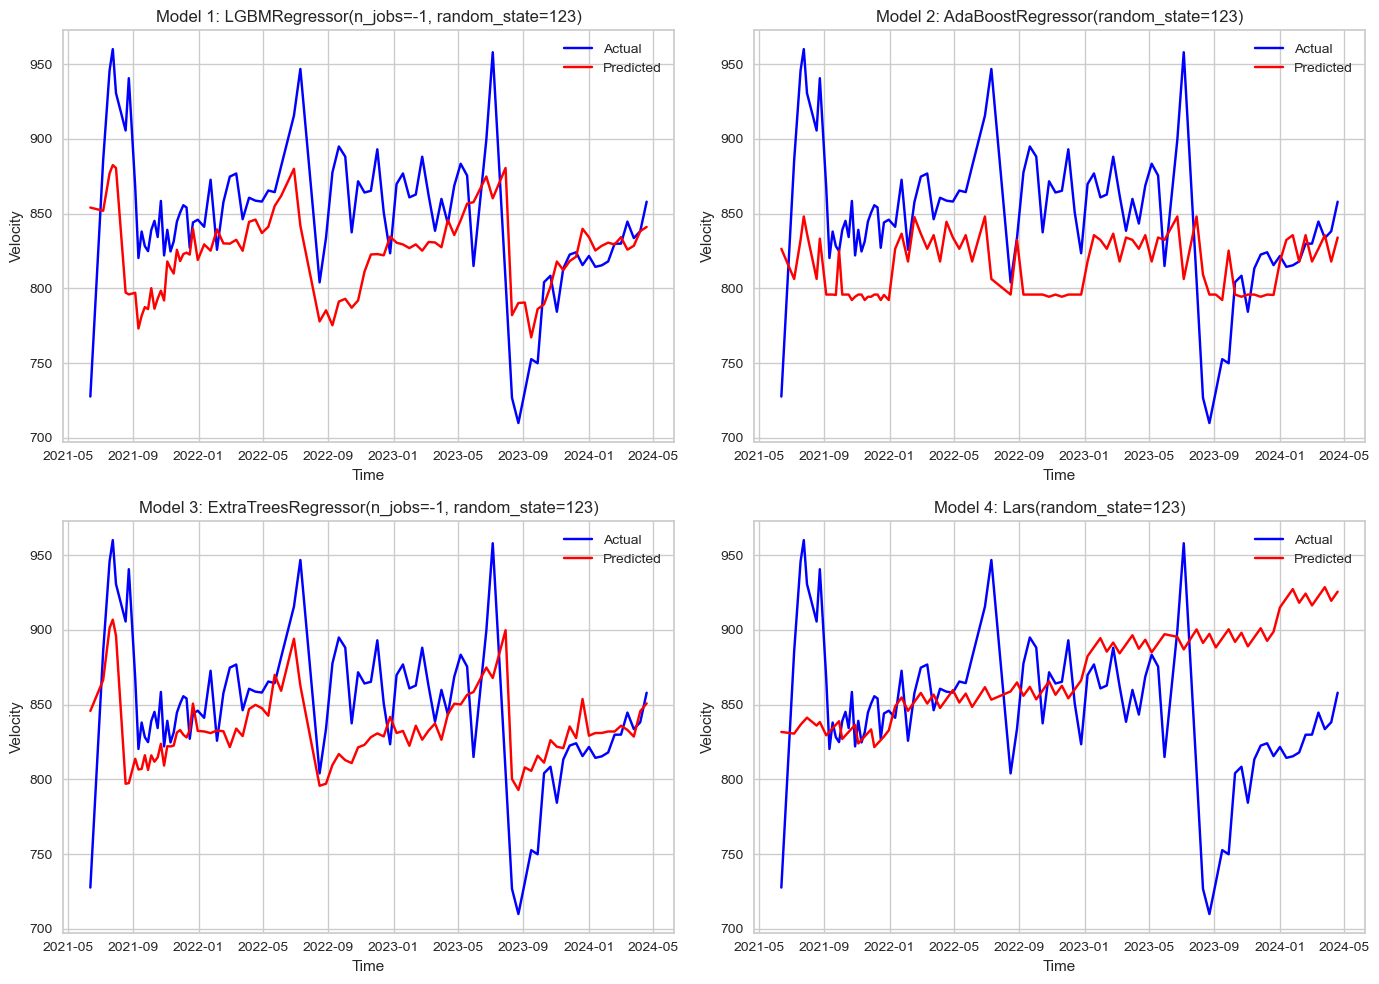

In [179]:
# Plot the results of the top 4 models
plt.figure(figsize=(14, 10))

for i, model in enumerate(comparison):
    # Predict on the test data
    predictions = predict_model(model, data=test)
    
    # Plot actual vs predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(test['time'], test['velocity'], label='Actual', color='blue')
    plt.plot(test['time'], predictions['prediction_label'], label='Predicted', color='red')
    plt.title(f'Model {i+1}: {model}')
    plt.xlabel('Time')
    plt.ylabel('Velocity')
    plt.legend()

plt.tight_layout()
plt.show()

It is important to pick the model that captures the long- and short-term trends.

For further analysis, let's plot the error to visualize the best fit for each model.

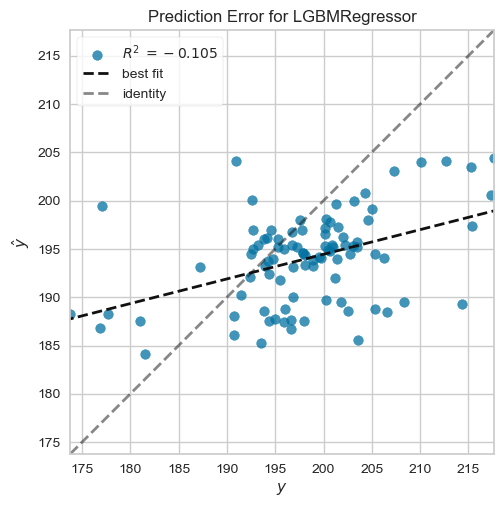

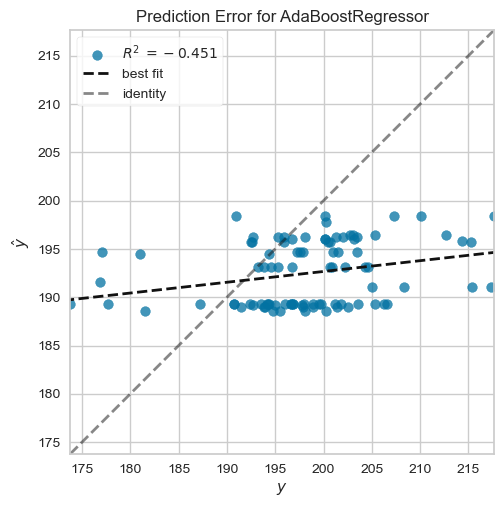

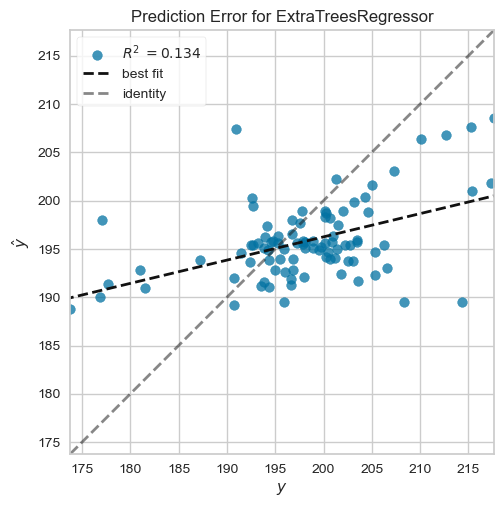

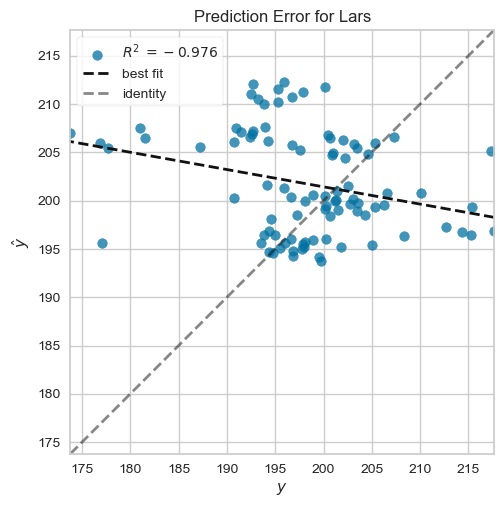

In [180]:
for model in comparison:
    plot_model(model, plot='error')

Here, it is easier to visualize how each model performed. The best fit line should ideally fit the data points. We'll grab the best model and use that moving forward.

### 5. Tune the model

Here we use hyperparameter tuning to optimize our model. We'll optimize it under mean absolute error (MAE).

In [181]:
dt = create_model(comparison[0])

tune_model(dt, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,27.1977,1361.6277,36.9002,-0.0001,0.0461,0.0343
1,33.7434,2795.9952,52.8772,-0.3780,0.0626,0.0398
2,35.6853,2306.0463,48.0213,-0.4004,0.0578,0.0428
3,40.6518,3008.2861,54.8478,-0.0755,0.0658,0.0485
4,17.1048,458.7571,21.4186,-0.4858,0.0256,0.0204
5,43.7904,5288.3960,72.7214,-0.2191,0.0946,0.0596
6,24.0650,733.5821,27.0847,-1.9388,0.0337,0.0294
7,42.4278,3724.3300,61.0273,-0.8256,0.0695,0.0470
8,32.4390,2164.6856,46.5262,-2.5684,0.0571,0.0415


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,27.1977,1361.6277,36.9002,-0.0001,0.0461,0.0343
1,34.8065,2865.5239,53.5306,-0.4122,0.0635,0.0411
2,45.7104,3117.0066,55.8302,-0.8929,0.0676,0.0543
3,59.2298,4907.7586,70.0554,-0.7545,0.0841,0.0695
4,45.2348,2249.5536,47.4295,-6.2859,0.0576,0.0535
5,53.5419,4435.2932,66.5980,-0.0224,0.0859,0.0687
6,11.7139,182.9024,13.5241,0.2673,0.0165,0.0144
7,35.9542,2706.1994,52.0211,-0.3265,0.0588,0.0400
8,20.0051,953.1477,30.8731,-0.5712,0.0387,0.0256


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


LGBMRegressor(n_jobs=-1, random_state=123)

Hyperparameter tuning might not affect the MSE score much but we'll take what we can get. Here, we can see that changing small parameters in the decision tree like the `max_depth` and `min_samples_leaf` can make a difference in model performance.

### 6. Time analysis

Now, let's plot the time analysis of the top models. Since we plan to run these models on larger datasets in future project tiers, it is important that they do not take up too much time.

Plot the amount of time each model took to run on the data. While this is good information for a small dataset, it will likely need to be run again for larger datasets in future project tiers.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,45.5108,3118.1159,55.8401,-0.4555,0.0663,0.0531


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,32.4732,1857.3332,43.0968,0.1330,0.0514,0.0384


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,47.9550,4259.5550,65.2653,-0.9883,0.0771,0.0581


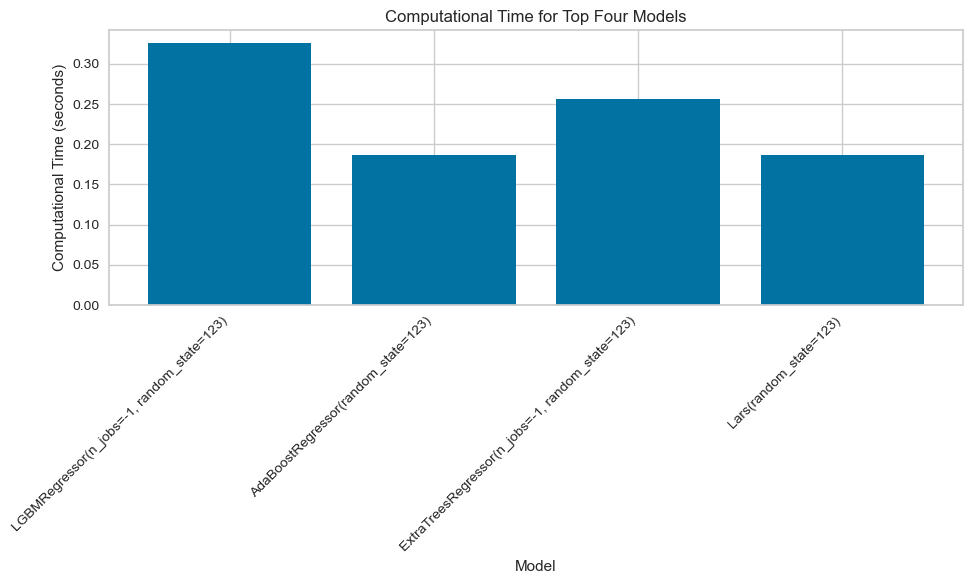

In [182]:
# Initialize a dictionary to store the computational times
comp_times = {}

# Measure the computational time for each model
for model in comparison:
    start_time = time.time()
    predict_model(model, data=test)
    end_time = time.time()
    
    # Calculate the computational time
    comp_time = end_time - start_time
    comp_times[model] = comp_time

# Plot the computational times
plt.figure(figsize=(10, 6))
plt.bar(range(len(comp_times)), list(comp_times.values()), align='center')
plt.xticks(range(len(comp_times)), [str(model) for model in comp_times.keys()], rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Computational Time (seconds)')
plt.title('Computational Time for Top Four Models')
plt.tight_layout()
plt.show()

It is important to consider the model with the least computational time **and** the model with the best performance.

### 7. Save the model

Save the model for future use.

In [183]:
save_model(dt, '../models/' + point_name + '_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('target_transformation',
                  TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                 ('date_feature_extractor',
                  TransformerWrapper(include=['time'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['time', 'series'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model', LGBMRegressor(n_jobs=-1, random_state=123))]),
 '../models/middle_model.pkl')

# Predict values

Here, we will take the trained and tuned model and use it to predict future values at the desired points.

### 1. Load model and data

In [184]:
model = load_model('../models/' + point_name + '_model')
model = comparison[0]

Transformation Pipeline and Model Successfully Loaded


In [185]:
df['time'] = pd.to_datetime(df['time'])  # Ensure date is datetime type
df = df.set_index('time').resample('6D').mean(numeric_only=True)  # Resample to every 6 days frequency
df = df.interpolate()  # Interpolate missing values
df.reset_index(inplace=True)  # Reset index
df.head()

,time,series,velocity
0,2015-01-30,1.000000,779.535340
1,2015-02-05,1.500000,758.979735
2,2015-02-11,2.000000,738.424130
3,2015-02-17,2.035714,738.549458
4,2015-02-23,2.071429,738.674785


### 2. Visualize test data

The data were split into training and test data. Here we visualize the predictions for the training data and predictions for the test set (highlighted in light gray).

In [186]:
# Ensure the 'time' column is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Generate predictions and use the original time column
predictions = predict_model(model, data=df)
predictions['time'] = df['time']  # Ensure this matches your data

# Ensure the lengths match
predictions = predictions.iloc[:len(df)]

# Plot
fig = px.line(predictions, x='time', y=["velocity", "prediction_label"])
fig.add_vrect(x0="2021-06-01", x1="2024-04-18", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,29.0988,1598.3010,39.9788,0.4491,0.0485,0.0354


### 3. Predict future values

The model is now trained and we can predict into the future. Let's start with values 4 years out at a frequency of 6 days.

Here we create a dataset with time and series values, like our original dataframe. The model will fill in the velocity prediction values.

In [187]:
future_dates = pd.date_range(start = '2024-04-24', end = '2028-04-30', freq = '6D')

future_df = pd.DataFrame()

future_df['time'] = future_dates
future_df['series'] = np.arange(145,(145+len(future_dates)))

future_df.head()

,time,series
0,2024-04-24,145
1,2024-04-30,146
2,2024-05-06,147
3,2024-05-12,148
4,2024-05-18,149


Make predictions on the future values.

In [188]:
predictions_future = predict_model(model, data=future_df)
predictions_future.head()

,time,series,prediction_label
0,2024-04-24,145,847.224703
1,2024-04-30,146,855.757752
2,2024-05-06,147,846.847718
3,2024-05-12,148,862.072006
4,2024-05-18,149,862.538864


Plot the original data and the future predictions.

In [189]:
concat_df = pd.concat([df,predictions_future], axis=0)
if point_name == 'upstream':
    concat_df_i = pd.date_range(start=df['time'].iloc[0], end=predictions_future['time'].iloc[-1] + pd.Timedelta(days=6), freq='6D')
else:
    concat_df_i = pd.date_range(start=df['time'].iloc[0], end=predictions_future['time'].iloc[-1], freq='6D')
concat_df.set_index(concat_df_i, inplace=True)

fig = px.line(concat_df, x=concat_df.index, y=["velocity", "prediction_label"])
fig.write_image('../figures/future_preds_' + point_name + '.png')
fig.show()